# First ICU Prediction using Scikit-Learn Classifiers for Baseline

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys
sys.path.append('../')

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

from collections import OrderedDict
from functools import partial
from sklearn.metrics import *

import torch
from torch import nn
from torch import optim

from ignite.engine import Events, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler

from cnn_classifier.dataset import NoteDataset
from cnn_classifier.model import NoteClassifier
from cnn_classifier.containers import ModelContainer, DataContainer
from cnn_classifier.trainer import IgniteTrainer
from utils.embeddings import PretrainedEmbeddings
from utils.plots import *
from utils.metrics import BinaryAvgMetrics, get_best_model

from utils.splits import *
from args import args
vars(args)

{'workdir': PosixPath('../data/work_dir/cnn'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'batch_size': 512,
 'min_freq': 3,
 'hidden_dim': 100,
 'dropout_p': 0.1,
 'emb_dropout': 0.1,
 'n_channels': 100,
 'lr': 0.001,
 'wd': 0.0,
 'n_epochs': 15,
 'checkpointer_save_total': 100,
 'emb_path': PosixPath('../pretrained/glove/glove.6B.50d.txt'),
 'emb_sz': 50,
 'checkpointer_prefix': 'glove50',
 'device': 'cuda:3',
 'checkpointer_name': 'classifier',
 'checkpointer_save_every': 1,
 'early_stop_patience': 10,
 'bc_threshold': 0.23,
 'cols': ['class_label', 'scispacy_note'],
 'start_seed': 127}

In [5]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
df = set_all_splits(ori_df.copy(), 0.1, 0.1, seed=seed)

## Functions

In [7]:
def get_sample(df, sample_pct=0.01, with_val=True, seed=None):
  train = df.loc[(df['split']) == 'train'].sample(frac=sample_pct, random_state=seed)
  train.reset_index(inplace=True, drop=True)

  if with_val:
    val = df.loc[(df['split']) == 'val'].sample(frac=sample_pct, random_state=seed)
    val.reset_index(inplace=True, drop=True)
    return pd.concat([train, val], axis=0) 

  return train

def convert_probs(output, thresh):
  y_pred, y = output
  y_pred = (torch.sigmoid(y_pred) > thresh).long()
  return y_pred, y

def predict_proba(clf, x_test):
  return torch.sigmoid(clf(x_test)).detach().numpy()

## Sample Training

In [ ]:
sample_df = get_sample(df)
sample_df.shape

In [18]:
dc = DataContainer(df, NoteDataset, args.workdir, bs=args.batch_size, with_test=True,\
                   min_freq=args.min_freq, create_vec=True, weighted_sampling=True)
itr = iter(dc.train_dl)

pe = PretrainedEmbeddings.from_file(args.emb_path)
pe.make_custom_embeddings(dc.get_vocab_tokens())

classifier = NoteClassifier(args.emb_sz, dc.get_vocab_size(), args.n_channels, args.hidden_dim, dc.n_classes,\
                            dropout_p=args.dropout_p, emb_dropout=args.emb_dropout,\
                            pretrained=pe.custom_embeddings)

In [10]:
optimizer = optim.Adam(classifier.parameters(), lr=args.lr, weight_decay=args.wd)
reduce_lr = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 1)
loss_fn = nn.BCEWithLogitsLoss()

mc = ModelContainer(classifier, loss_fn, optimizer, reduce_lr)

In [11]:
x, y = next(itr)
y_pred = classifier(x)
print(loss_fn(y_pred, y))

tensor(0.6932, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [12]:
bce_logits_wrapper = partial(convert_probs, thresh=args.bc_threshold)
metrics = OrderedDict({ 'loss': Loss(loss_fn)})
ig = IgniteTrainer(mc, dc, args, metrics, log_training=True, early_stop=True)
model_name = ig.run()

Epoch [1/15]: [79/79] 100%|██████████, loss=6.44e-01 [02:10<00:00]


Training loss 0.607 
Validation loss 0.615 


Epoch [2/15]: [79/79] 100%|██████████, loss=5.96e-01 [02:06<00:00]


Training loss 0.577 
Validation loss 0.591 


Epoch [3/15]: [79/79] 100%|██████████, loss=5.48e-01 [02:03<00:00]


Training loss 0.512 
Validation loss 0.577 


Epoch [4/15]: [79/79] 100%|██████████, loss=4.85e-01 [02:04<00:00]


Training loss 0.454 
Validation loss 0.504 


Epoch [5/15]: [79/79] 100%|██████████, loss=4.35e-01 [02:04<00:00]


Training loss 0.415 
Validation loss 0.466 


Epoch [6/15]: [79/79] 100%|██████████, loss=3.90e-01 [02:11<00:00]


Training loss 0.366 
Validation loss 0.451 


Epoch [7/15]: [79/79] 100%|██████████, loss=3.62e-01 [02:09<00:00]


Training loss 0.349 
Validation loss 0.562 


Epoch [8/15]: [79/79] 100%|██████████, loss=3.38e-01 [02:07<00:00]


Training loss 0.293 
Validation loss 0.493 


Epoch [9/15]: [79/79] 100%|██████████, loss=3.00e-01 [02:04<00:00]


Training loss 0.288 
Validation loss 0.544 


Epoch [10/15]: [79/79] 100%|██████████, loss=2.90e-01 [02:06<00:00]


Training loss 0.261 
Validation loss 0.541 


Epoch [11/15]: [79/79] 100%|██████████, loss=2.71e-01 [02:13<00:00]


Training loss 0.250 
Validation loss 0.523 


Epoch [12/15]: [79/79] 100%|██████████, loss=2.60e-01 [02:04<00:00]


Training loss 0.240 
Validation loss 0.533 


Epoch [13/15]: [79/79] 100%|██████████, loss=2.59e-01 [02:01<00:00]


Training loss 0.230 
Validation loss 0.540 


Epoch [14/15]: [79/79] 100%|██████████, loss=2.49e-01 [02:04<00:00]


Training loss 0.246 
Validation loss 0.575 


Epoch [15/15]: [79/79] 100%|██████████, loss=2.50e-01 [02:08<00:00]


Training loss 0.225 
Validation loss 0.548 


In [19]:
x_test, targ = next(iter(dc.test_dl))
x_test = x_test.to('cpu')
targ = targ.to('cpu')
classifier = classifier.to('cpu')

In [26]:
prob = predict_proba(classifier, x_test)
pred = (prob > args.bc_threshold).astype(np.int64)

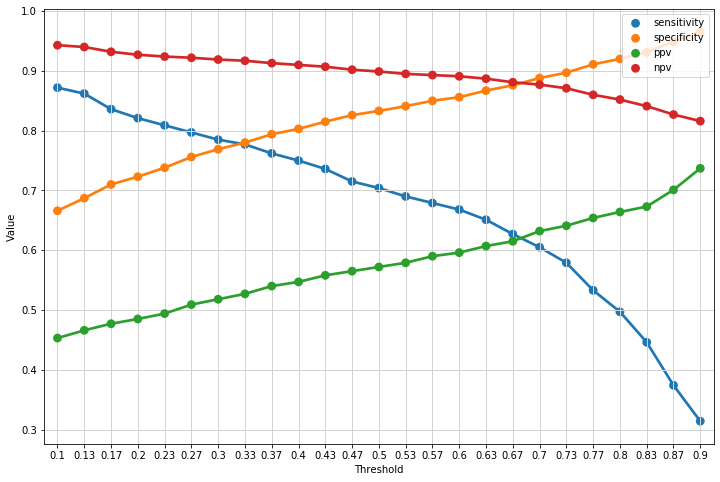

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, targ, prob, 0.1, 0.9, 25)

In [29]:
cm = confusion_matrix(targ, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(targ, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.809
specificity,0.738
ppv,0.494
npv,0.924
f1,0.614
auroc,0.858
prevalence,0.241


In [13]:
model_name

'glove50_classifier_6.pth'

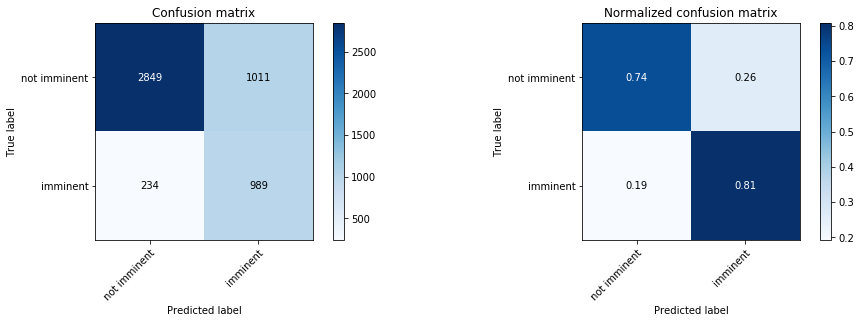

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['not imminent', 'imminent'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

## Testing

In [ ]:
dc = DataContainer(df, NoteDataset, args.workdir, bs=args.batch_size, with_test=True,\
                   min_freq=args.min_freq, load_vec=True)

print(dc.get_dataset_size())
print(dc.get_batch_sizes())
print(dc.get_num_batches())

In [ ]:
pe = PretrainedEmbeddings.from_file(args.emb_path)
pe.make_custom_embeddings(dc.get_vocab_tokens())

classifier = NoteClassifier(args.emb_sz, dc.get_vocab_size(), args.n_channels, args.hidden_dim, dc.n_classes,\
                            dropout_p=args.dropout_p, pretrained=pe.custom_embeddings)

state_dict = torch.load(args.modelfile)
classifier.load_state_dict(state_dict);

### Plots

In [ ]:
log = pd.read_csv(args.workdir/'training_log.csv')
log = log[:-1]
log.head()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
log.plot(x='epoch', y=['training_loss', 'validation_loss'], kind='line',
                      title='Training and validation loss', ax=axes[0][0])
log.plot(x='epoch', y=['training_accuracy', 'validation_accuracy'], kind='line',
                      title='Training and validation accuracy', ax=axes[0][1])
log.plot(x='epoch', y=['training_precision', 'validation_precision'], kind='line',
                      title='Training and validation precision', ax=axes[1][0])
log.plot(x='epoch', y=['training_recall', 'validation_recall'], kind='line',
                      title='Training and validation recall', ax=axes[1][1])

### Test set

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
bce_logits_wrapper = partial(convert_probs, thresh=args.bc_threshold)
metrics = OrderedDict({ 'loss': Loss(loss_fn), 'sensitivity': Recall(bce_logits_wrapper),\
                       'ppv': Precision(bce_logits_wrapper)})

In [ ]:
evaluator = create_supervised_evaluator(classifier, metrics=metrics)

@evaluator.on(Events.COMPLETED)
def log_testing_results(engine):
  metrics = engine.state.metrics
  for metric in metrics.keys():
    print(f"{metric} {metrics[metric]:0.3f}")

evaluator.run(dc.test_dl)

### Interpretation

In [ ]:
# sort weights
emb = classifier.emb.weight.detach()[0]
_, idxs = torch.sort(emb, dim=0, descending=True)
idxs = idxs.numpy().tolist()

In [ ]:
# Top 20 words
print("Influential words in positive class:")
print("--------------------------------------")
for i in range(20):
    print(dc.vectorizer.vocab.lookup_idx(idxs[i]))
    
print("====\n\n\n")

In [ ]:
# Top 20 words
print("Influential words in negative class:")
print("--------------------------------------")
idxs.reverse()
for i in range(20):
    print(dc.vectorizer.vocab.lookup_idx(idxs[i]))
    
print("====\n\n\n")

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

In [ ]:
with open(args.workdir/'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

In [ ]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam.get_avg_metrics()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()